In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
from glob import glob

In [2]:
path_tiny = '/home/sogangori/Downloads/tiny_set/'
path_tiny_certain_train = path_tiny + 'erase_with_uncertain_dataset/train/'
path_tiny_certain_test = path_tiny + 'erase_with_uncertain_dataset/test/'

In [3]:
path_tiny_annotation = path_tiny + 'annotations/tiny_set_train.json'
path_tiny_annotation

'/home/sogangori/Downloads/tiny_set/annotations/tiny_set_train.json'

In [4]:
#os.path.isfile('/home/sogangori/Downloads/tiny_set/annotations/tiny_set_train.json')
os.path.isfile(path_tiny_annotation)

True

In [5]:
with open(path_tiny_annotation, 'r') as j:
    contents = json.loads(j.read())                    

In [6]:
contents

{'type': 'instance',
 'annotations': [{'segmentation': [[1081.124389319407,
     17.45930926910859,
     1267.431666947439,
     17.45930926910859,
     1267.431666947439,
     67.73270164492683,
     1081.124389319407,
     67.73270164492683]],
   'bbox': [1081.124389319407,
    17.45930926910859,
    186.3072776280319,
    50.27339237581825],
   'category_id': 1,
   'area': 9366.298870664552,
   'iscrowd': 0,
   'image_id': 0,
   'id': 0,
   'ignore': True,
   'uncertain': False,
   'logo': True,
   'in_dense_image': False},
  {'segmentation': [[517.3621985215059,
     323.7494218755995,
     536.3942919951216,
     323.7494218755995,
     536.3942919951216,
     360.0675452013983,
     517.3621985215059,
     360.0675452013983]],
   'bbox': [517.3621985215059,
    323.7494218755995,
    19.03209347361576,
    36.31812332579875],
   'category_id': 1,
   'area': 691.2099179229067,
   'iscrowd': 0,
   'image_id': 0,
   'id': 1,
   'ignore': False,
   'uncertain': False,
   'logo': Fals

In [7]:
len(contents), contents.keys()

(4, dict_keys(['type', 'annotations', 'images', 'categories']))

In [8]:
images = contents['images']
annotations = contents['annotations']
print(len(images), type(images), images[:2])
print(len(annotations), type(annotations), annotations[0])

746 <class 'list'> [{'file_name': 'labeled_images/bb_V0032_I0001640.jpg', 'height': 720, 'width': 1280, 'id': 0}, {'file_name': 'labeled_images/bb_V0014_I0002600.jpg', 'height': 1080, 'width': 1920, 'id': 1}]
25288 <class 'list'> {'segmentation': [[1081.124389319407, 17.45930926910859, 1267.431666947439, 17.45930926910859, 1267.431666947439, 67.73270164492683, 1081.124389319407, 67.73270164492683]], 'bbox': [1081.124389319407, 17.45930926910859, 186.3072776280319, 50.27339237581825], 'category_id': 1, 'area': 9366.298870664552, 'iscrowd': 0, 'image_id': 0, 'id': 0, 'ignore': True, 'uncertain': False, 'logo': True, 'in_dense_image': False}


In [9]:
file_name_id_dict = dict()
for image in images:
    file_name = image['file_name']
    id_num = image['id']
    if 'labeled' in file_name:
        file_name_id_dict[file_name] = id_num

In [10]:
id_values = file_name_id_dict.values()
len(id_values), len(set(id_values)), min(id_values), max(id_values)

(717, 717, 0, 716)

In [11]:
id_bbox_dict = dict()
for annotation in annotations:    
    image_id = annotation['image_id']
    bbox = annotation['bbox']
    ignore = annotation['ignore']
    uncertain = annotation['uncertain']
        
    bbox = np.array(bbox, dtype=np.int)
    x, y, w, h = bbox
    bbox = [y, x, y+h, x+w]
    #print('bbox', bbox)
    #break
    
    if ignore:
        #print(image_id, bbox, ignore, uncertain)
        pass
    else:
        if image_id in id_bbox_dict.keys():
            id_bbox_dict[image_id].extend(bbox)
        else:
            id_bbox_dict[image_id] = bbox

In [12]:
np.array(id_bbox_dict[1]).reshape([-1, 4]).shape

(82, 4)

In [13]:
path_tiny_certain_train, path_tiny_certain_test

('/home/sogangori/Downloads/tiny_set/erase_with_uncertain_dataset/train/',
 '/home/sogangori/Downloads/tiny_set/erase_with_uncertain_dataset/test/')

In [14]:
annotation_train = dict()
annotation_test = dict()
for file_name in file_name_id_dict.keys():
    file_full_path_train = path_tiny_certain_train + file_name
    file_full_path_test = path_tiny_certain_test + file_name
    
    file_id = file_name_id_dict[file_name]
    bboxes = id_bbox_dict[file_id]
    bboxes_2d = np.reshape(bboxes, [-1, 4])
        
    if os.path.isfile(file_full_path_train):        
        annotation_train[file_full_path_train] = bboxes_2d        
    elif os.path.isfile(file_full_path_test):
        annotation_test[file_full_path_test] = bboxes_2d        

In [15]:
len(annotation_train), len(annotation_test)

(717, 0)

In [16]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    img_h, img_w, img_c = image.shape
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 3] - boxes[:, 1]
    boxes_height = boxes[:, 2] - boxes[:, 0]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        y1, x1, y2, x2 = box        
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        
    plt.show()
    return ax

715 /home/sogangori/Downloads/tiny_set/erase_with_uncertain_dataset/train/labeled_images/bb_V0033_I0000200.jpg (6, 4)


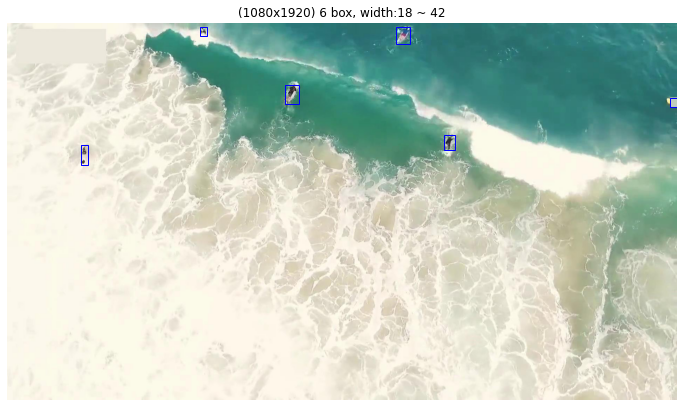

In [19]:
sample_path, sample_box  = annotation_train.popitem()
print(len(annotation_train), sample_path, sample_box.shape)

image = Image.open(sample_path)
label = np.ones_like(sample_box[:, 0])
bbox = sample_box

ax = visualize_detections_simple(image,bbox,label)